# Проект для «Викишоп» 📑

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Цель проекта:** Обучить модель классифицировать комментарии на позитивные и негативные.






**Содержание**<a id='toc0_'></a> 

1. [Подготовка данных](#toc1_)                                  
  1.1 [Установка библиотек и конфигурации](#toc1_1_)    
  1.2 [Функции, используемые в проекте](#toc1_2_)                                                              
 
2. [Анализ данных](#toc2_)         
                      
3. [Обучение моделей](#toc3_)                                                     
  3.1 [LinearClassifier](#toc3_1_)    
  3.2 [RandomForestClassifier](#toc3_2_)                         
  3.3 [LGBMClassifier](#toc3_3_)                                                            

4. [Тестирование](#toc4_)                                             
  
5. [Вывод](#toc5_)

## <a id='toc1_'></a> 1. Подготовка данных[&#8593;](#toc0_)

### <a id='toc1_1_'></a> 1.1 Установка библиотек  и конфигурации [&#8593;](#toc0_)

In [1]:
from IPython.display import clear_output

In [2]:
from platform import python_version
version = python_version()

if version.startswith('3.9'):  
    pass
    %pip install --force-reinstall -v "numpy==1.22.4" -q
else: 
    pass
    %pip install --upgrade numpy -q   

%pip install --force-reinstall -v "matplotlib==3.8.0" -q

%pip install --upgrade phik -q
%pip install --upgrade prettytable -q
%pip install --upgrade termcolor -q
%pip install --upgrade seaborn -q
%pip install --upgrade pandas -q
%pip install --upgrade statsmodels -q
%pip install --upgrade scikit-learn -q
%pip install --upgrade shap -q
%pip install --upgrade imbalanced-learn -q
%pip install --upgrade optuna -q 
%pip install --upgrade nltk -q
%pip install --upgrade re -q
%pip install --upgrade torch -q
clear_output()

In [3]:
%pip install --upgrade transformers -q
clear_output()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import re
import missingno as msno
import torch
import transformers 

import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from imblearn.over_sampling import SMOTE

from os.path import exists

# preprocessing
from sklearn.model_selection import (
    GridSearchCV,                                 
    train_test_split)
from sklearn.impute import (
    SimpleImputer)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.under_sampling import RandomUnderSampler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# metrics
from sklearn.metrics import (
     f1_score,
     ConfusionMatrixDisplay)
# additional tools
from prettytable import PrettyTable
from termcolor import colored
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Евгений\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Евгений\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [5]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)

### <a id='toc1_2_'></a> 1.2 Функции, используемые в проекте [&#8593;](#toc0_)

In [6]:
def get_dataframe(paths: list[str]) -> pd.DataFrame:
    for _path in paths:
        if not exists(_path) and not _path.startswith('http'):
            continue
        
        try:
            df = pd.read_csv(_path)
        except:
            continue
        
        if df is None:
            continue
        
        return df
    
    raise FileNotFoundError('No paths are valid and/or for correct csv file.')

In [7]:
def print_nans_table(data: pd.DataFrame) -> None:
    table = PrettyTable()
    table.field_names = ['Признаки', 'Пропущенное количество значений']
    
    missing_info = data.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'blue' if count == 0 else 'red'
        s = f'{count} ({count / len(data):.1%})'
        table.add_row([col, colored(s, color)])
    
    print(table)

## <a id='toc2_'></a> 2. Анализ данных[&#8593;](#toc0_)

1. Загрузим данные и проведем предобработку:

In [8]:
df = get_dataframe(['datasets/toxic_comments.csv'])

In [9]:
df.head(10)

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,9,alignment on this subject and which are contrary to those of DuLithgow,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [11]:
print_nans_table(df)

+------------+---------------------------------+
|  Признаки  | Пропущенное количество значений |
+------------+---------------------------------+
| Unnamed: 0 |             0 (0.0%)            |
|    text    |             0 (0.0%)            |
|   toxic    |             0 (0.0%)            |
+------------+---------------------------------+


In [12]:
df['Unnamed: 0'].unique()

array([     0,      1,      2, ..., 159448, 159449, 159450], dtype=int64)

In [13]:
df['Unnamed: 0'].duplicated().sum()

0

In [14]:
df = df.rename(columns={'Unnamed: 0': 'id'})

In [15]:
df = df.set_index('id')
df = df.sort_index()

In [16]:
df.index.is_monotonic_increasing

True

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [18]:
df.head(10)

,text,toxic
id,,
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0


In [19]:
df.toxic.unique()

array([0, 1], dtype=int64)

In [20]:
df.loc[df['toxic']==0]['text'].count()

143106

In [21]:
df.loc[df['toxic']==1]['text'].count()

16186

In [22]:
df.loc[df['toxic']==0]['text'].count()/df.loc[df['toxic']==1]['text'].count()

8.841344371679229

**Вывод:** В ходе предобработки выяснили, что в данных нет дубликатов и пропусков. В качестве индекса обозначили первый столбец и отсортировали его по возрастанию. Наблюдается дисбаланс классов, который необходимо будет учесть при подготовке данных для моделей.

2. Далее необходимо провести лемматизацию

In [23]:
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')


def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [24]:
df['lemmatize'] = df['text'].apply(lambda x: lemmatize_sentence(x))

In [25]:
df.head()

,text,toxic,lemmatize
id,,,
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,"Explanation Why the edits make under my username Hardcore Metallica Fan be revert ? They be n't vandalisms , just closure on some GAs after I vote at New York Dolls FAC . And please do n't remove the template from the talk page since I 'm retired now.89.205.38.27"
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,"D'aww ! He match this background colour I 'm seemingly stick with . Thanks . ( talk ) 21:51 , January 11 , 2016 ( UTC )"
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,"Hey man , I 'm really not try to edit war . It 's just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page . He seem to care more about the formatting than the actual info ."
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,"`` More I ca n't make any real suggestion on improvement - I wonder if the section statistic should be later on , or a subsection of `` '' type of accident '' '' -I think the reference may need tidy so that they be all in the exact same format ie date format etc . I can do that later on , if no-one else do first - if you have any preference for format style on reference or want to do it yourself please let me know . There appear to be a backlog on article for review so I guess there may be a delay until a reviewer turn up . It 's list in the relevant form eg Wikipedia : Good_article_nominations # Transport ``"
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,"You , sir , be my hero . Any chance you remember what page that 's on ?"


In [26]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = text.split()
    text = " ".join(text)
    return text

In [27]:
df['lemmatize'] = df['lemmatize'].apply(lambda x: clear_text(x))

In [28]:
df['lemmatize'] = df['lemmatize'].apply(lambda x: x.lower())

In [29]:
df.head()

,text,toxic,lemmatize
id,,,
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edits make under my username hardcore metallica fan be revert they be n t vandalisms just closure on some gas after i vote at new york dolls fac and please do n t remove the template from the talk page since i m retired now
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d aww he match this background colour i m seemingly stick with thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man i m really not try to edit war it s just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page he seem to care more about the formatting than the actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,more i ca n t make any real suggestion on improvement i wonder if the section statistic should be later on or a subsection of type of accident i think the reference may need tidy so that they be all in the exact same format ie date format etc i can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let me know there appear to be a backlog on article for review so i guess there may be a delay until a reviewer turn up it s list in the relevant form eg wikipedia good article nominations transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,you sir be my hero any chance you remember what page that s on


## <a id='toc3_'></a> 3. Обучение моделей[&#8593;](#toc0_)

In [30]:
X = df.drop('toxic', axis=1)

In [31]:
y = df['toxic']

В самом начале был заметен дисбаланс классов, воспользуемся андерсемплингом:

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=TEST_SIZE, random_state = RANDOM_STATE,stratify=y)

### <a id='toc3_1_'></a> 3.1 LogisticRegression [&#8593;](#toc0_)

In [33]:
count_tf_idf_train = TfidfVectorizer(stop_words=stop)
tf_idf_train_lr = count_tf_idf_train.fit_transform(X_train.lemmatize)

In [34]:
display(tf_idf_train_lr.shape)

(127433, 141164)

In [35]:
model = LogisticRegression(n_jobs=-1,random_state = RANDOM_STATE,class_weight='balanced') 

In [36]:
model.fit(tf_idf_train_lr, y_train)

LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42)

In [37]:
f1_score(y_train, model.predict(tf_idf_train_lr))

0.8240071308309399

Более чем удовлетворительный результат метрики на тренировочных данных.

### <a id='toc3_2_'></a> 3.2 RandomForestClassifier [&#8593;](#toc0_)

In [38]:
kf = KFold(n_splits=5, shuffle=False)

In [39]:
tf_idf_train_RFC = count_tf_idf_train.fit_transform(X_train.lemmatize)

In [40]:
display(tf_idf_train_RFC.shape)

(127433, 141164)

In [41]:
final_pipe_RFC = Pipeline(
    [
        (
        'model', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1,class_weight='balanced'))
    ]
)

In [42]:
param_grid_RFC = {
    'model__n_estimators': [500],
    'model__min_samples_split': range(3, 4),
    'model__min_samples_leaf': range(3, 4)
}

In [43]:
grid_RFC = GridSearchCV(
    final_pipe_RFC,
    param_grid=param_grid_RFC,
    scoring= 'f1',
    cv=kf
)

In [44]:
%%time
grid_RFC.fit(tf_idf_train_RFC, y_train)

CPU times: total: 7h 38min 10s
Wall time: 1h 5min 2s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             param_grid={'model__min_samples_leaf': range(3, 4),
                         'model__min_samples_split': range(3, 4),
                         'model__n_estimators': [500]},
             scoring='f1')

In [45]:
grid_RFC.best_score_

0.6744078398322094

Метрика < 0,9 и значительно меньше чем у модели линейного классификатора.

### <a id='toc3_3_'></a> 3.3 LGBMClassifier [&#8593;](#toc0_)

In [46]:
tf_idf_train_LGBMC = count_tf_idf_train.fit_transform(X_train.lemmatize)

In [47]:
final_pipe_LGBMC = Pipeline(
    [  
        (
        'model', LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1,class_weight='balanced'))
    ]
)

In [48]:
param_grid_LGBMC = [

    {
    'model__learning_rate': [0.05, 0.3],
    'model__num_leaves': [20, 100],
    'model__max_depth': [7, 15]
    },
    
]

In [49]:
grid_LGBMC = GridSearchCV(
    final_pipe_LGBMC,
    param_grid=param_grid_LGBMC,
    scoring= 'f1',
    cv=kf
)

In [50]:
%%time
grid_LGBMC.fit(tf_idf_train_LGBMC, y_train)

C:\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.w

CPU times: total: 1h 1min 59s
Wall time: 14min 33s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('model',
                                        LGBMClassifier(class_weight='balanced',
                                                       n_jobs=-1,
                                                       random_state=42,
                                                       verbosity=-1))]),
             param_grid=[{'model__learning_rate': [0.05, 0.3],
                          'model__max_depth': [7, 15],
                          'model__num_leaves': [20, 100]}],
             scoring='f1')

In [51]:
grid_LGBMC.best_score_

0.7525661088845278

Метрика < 0,9 и так же меньше чем у модели линейного классификатора.

**Вывод:** Исходя из полученных результатов метрик на 3-х моделях, отметим, что Линейный классификатор показал достойное значение f1 = 0,82. Предсказывать значения на тестовых данных будем с помощью LogisticRegression

## <a id='toc4_'></a> 4. Тестирование[&#8593;](#toc0_)

In [52]:
count_tf_idf_test = TfidfVectorizer(stop_words=stopwords)
tf_idf_test_lr = count_tf_idf_train.transform(X_test.lemmatize)
display(tf_idf_test_lr.shape)

(31859, 141164)

In [53]:
y_pred = model.predict(tf_idf_test_lr)

In [54]:
round(f1_score(y_test, y_pred),2)

0.74

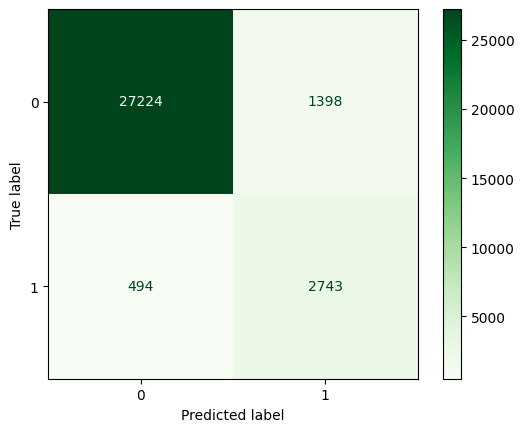

In [55]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greens')

## <a id='toc5_'></a> 5. Вывод[&#8593;](#toc0_)

Мы получили текстовые данные с отзывами.

В ходе предобработки выяснили, что присутствует столбец с id отзывов, поставили его на место индексов. Пропусков и дубликатов не обнаружили.

Далее была проведена лемматизация текстовых комментариев и приведение их к нижнему регистру.

В ходе подготовки данных использовали андерсемплинг (RandomUnderSampling) для устранения дисбаланса классов. 

Были обучены 3 модели с подбором различных гиперпараметров и вычисление TF-IDF для корпуса текстов. Лучшей моделью является LogisticRegression , которая показала метрику f1= 0,82 и 0,74 на тренировочных и тестовых данных соответственно.
